In [210]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

خواندن داده‌ها

In [211]:
data=pd.read_csv('water_dataX.csv',encoding="ISO-8859-1")
data.head()

,STATION CODE,LOCATIONS,STATE,Temp,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean,year
0,1393,"DAMANGANGA AT D/S OF MADHUBAN, DAMAN",DAMAN & DIU,30.6,6.7,7.5,203,NAN,0.1,11,27,2014
1,1399,ZUARI AT D/S OF PT. WHERE KUMBARJRIA CANAL JOI...,GOA,29.8,5.7,7.2,189,2,0.2,4953,8391,2014
2,1475,ZUARI AT PANCHAWADI,GOA,29.5,6.3,6.9,179,1.7,0.1,3243,5330,2014
3,3181,RIVER ZUARI AT BORIM BRIDGE,GOA,29.7,5.8,6.9,64,3.8,0.5,5382,8443,2014
4,3182,RIVER ZUARI AT MARCAIM JETTY,GOA,29.5,5.8,7.3,83,1.9,0.4,3428,5500,2014


انتخاب ستون ها

In [212]:
df = data.drop(columns=["STATION CODE", "LOCATIONS", "STATE", "Temp", "year"]).copy()
df.sample(5)

,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
1528,5,7.3,748,7.4,2.65,12500,90000
828,7.3,6.2,113,1.2,0.33,9,137
675,7,7.1,95,1.9,0.08,47,118
1590,6.8,6.9,7920,0.5,0.2,391,813
1971,6.9,142,7.3,2.2,NAN,NAN,1573


جایگزینی مقادیر گمشده با میانگین

In [213]:
from sklearn.impute import SimpleImputer

In [214]:
# تبدیل مقادیر غیرعددی به NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# تبدیل همه ستون‌ها به مقدار عددی (اگر هنوز داده‌های غیرعددی وجود داشته باشد)
df = df.apply(pd.to_numeric, errors='coerce')

In [215]:
imputer = SimpleImputer(strategy='mean')
df.iloc[:, :] = imputer.fit_transform(df)
df.head()

,D.O. (mg/l),PH,CONDUCTIVITY (µmhos/cm),B.O.D. (mg/l),NITRATENAN N+ NITRITENANN (mg/l),FECAL COLIFORM (MPN/100ml),TOTAL COLIFORM (MPN/100ml)Mean
0,6.7,7.5,203.0,6.940049,0.1,11.0,27.0
1,5.7,7.2,189.0,2.000000,0.2,4953.0,8391.0
2,6.3,6.9,179.0,1.700000,0.1,3243.0,5330.0
3,5.8,6.9,64.0,3.800000,0.5,5382.0,8443.0
4,5.8,7.3,83.0,1.900000,0.4,3428.0,5500.0


تغییر نام ستون ها

In [216]:
df.columns = ['do','ph','co','bod','na','fc','tc']
df.sample(5)

,do,ph,co,bod,na,fc,tc
1512,7.4,6.700,88.0,1.030,0.150000,89.000000,173.00000
1963,7.5,77.000,7.4,3.200,1.623079,362529.364718,65.00000
1699,7.0,6.725,497.3,1.575,0.135000,1956.000000,5425.00000
1885,4.2,8.520,380.0,1.260,0.160000,28.000000,1100.00000
1342,6.8,7.400,309.0,7.000,15.300000,362529.364718,533687.16568


محاسبه مقدار WQI

In [217]:
# مقدارهای استاندارد و ایده‌آل پارامترها
standard_values = {'do': 9, 'ph': 8.5, 'co': 1500, 'bod': 5.0, 'na': 50, 'fc': 200, 'tc': 1000}
ideal_values = {'do': 5.0, 'ph': 7.0, 'co': 500, 'bod': 0, 'na': 0, 'fc': 0, 'tc': 0}

# وزن‌های پارامترها (wi) از مقاله
weights = {'do': 0.2213, 'ph': 0.2604, 'co': 0.0022, 'bod': 0.4426, 'na': 0.0492, 'fc': 0.0227, 'tc': 0.0022}

# رنج معتبر پارامتر ها
param_ranges = {
    "do": 15,          # Assuming DO ranges between 0-15 mg/L
    "ph": 14,                        # pH ranges between 0-14
    "co": 1500,            # Based on standard si=1500 µS/cm
    "bod": 5,          # Based on standard si=5 mg/L
    "na": 50,                   # Based on standard si=50 mg/L
    "fc": 200,           # Based on standard si=200 CFU/100mL
    "tc": 5000,          # Based on standard si=5000 CFU/100mL
}

In [218]:
# تابع محاسبه مقدار qi برای هر پارامتر
def calculate_qi(df, column):
    vi = df[column]
    vid = ideal_values[column]
    si = standard_values[column]
    vi_clamped = vi.clip(upper=param_ranges[column])
    return 100 * abs(vi_clamped - vid) / (si - vid)

In [219]:
# محاسبه qi برای هر پارامتر
for col in standard_values.keys():
    df[f'qi_{col}'] = calculate_qi(df, col)

# محاسبه WQI طبق فرمول مقاله
df['WQI'] = df[[f'qi_{col}' for col in weights.keys()]].mul(weights.values()).sum(axis=1)

# حذف ستون های اضافی
df = df.drop(columns=["qi_do", "qi_ph", "qi_co", "qi_bod", "qi_na", "qi_fc", "qi_tc"])

# نمایش خروجی
df.head()

,do,ph,co,bod,na,fc,tc,WQI
0,6.7,7.5,203.0,6.940049,0.1,11.0,27.0,62.55122
1,5.7,7.2,189.0,2.000000,0.2,4953.0,8391.0,28.50685
2,6.3,6.9,179.0,1.700000,0.1,3243.0,5330.0,27.42711
3,5.8,6.9,64.0,3.800000,0.5,5382.0,8443.0,43.31472
4,5.8,7.3,83.0,1.900000,0.4,3428.0,5500.0,29.95390


Statistical calculation of the features

In [220]:
df.describe()

,do,ph,co,bod,na,fc,tc,WQI
count,1991.000000,1991.000000,1991.000000,1991.000000,1991.000000,1.991000e+03,1.991000e+03,1991.000000
mean,6.392637,112.090674,1786.466394,6.940049,1.623079,3.625294e+05,5.336872e+05,47.520568
std,1.322515,1875.150167,5517.289887,29.080653,3.852301,8.038807e+06,1.375409e+07,30.409380
min,0.000000,0.000000,0.400000,0.100000,0.000000,0.000000e+00,0.000000e+00,11.342824
25%,5.950000,6.900000,79.000000,1.200000,0.280000,4.100000e+01,1.180000e+02,28.541106
50%,6.700000,7.300000,187.630000,1.900000,0.620000,3.130000e+02,5.420000e+02,39.816730
75%,7.200000,7.700000,620.500000,3.900000,1.623079,4.950500e+03,2.929000e+03,56.738149
max,11.400000,67115.000000,65700.000000,534.500000,108.700000,2.725216e+08,5.110909e+08,183.823559


Heat map visualization of the feature correlations

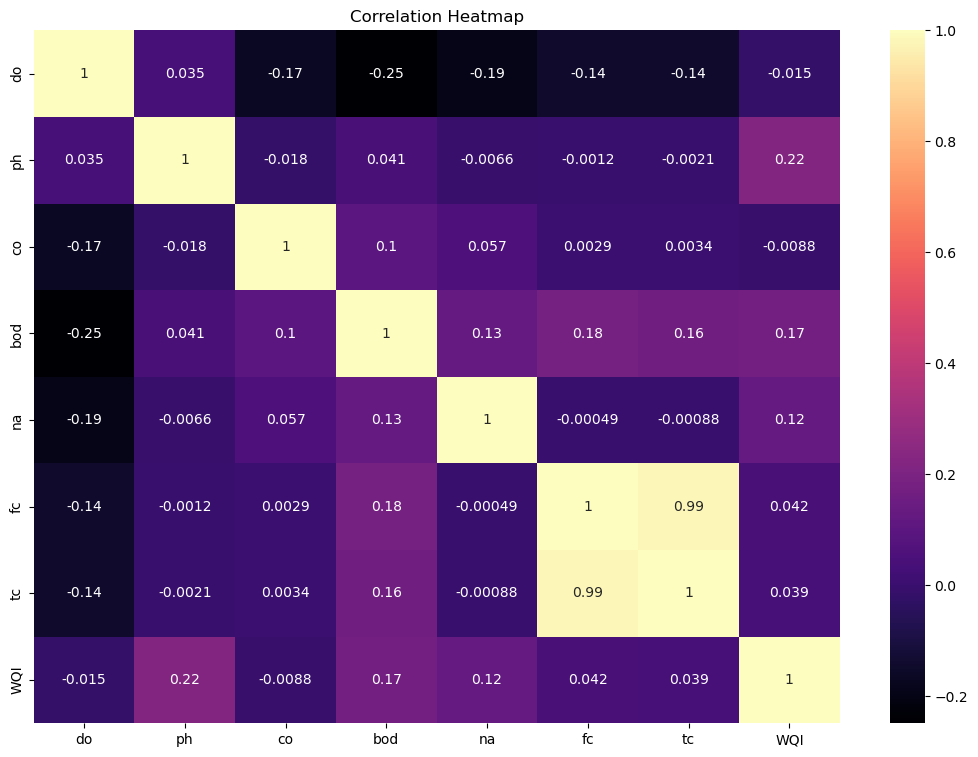

In [221]:
corr = df.corr()
fig, ax = plt.subplots(figsize=(13, 9))
sns.heatmap(corr, annot=True, cmap='magma', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

نرمال‌سازی داده‌ها

In [222]:
from sklearn.preprocessing import MinMaxScaler

In [223]:
scaler = MinMaxScaler()
df.iloc[:, :-1] = scaler.fit_transform(df.iloc[:, :-1]) 
df.head()

,do,ph,co,bod,na,fc,tc,WQI
0,0.587719,0.000112,0.003084,0.012799,0.00092,4.036377e-08,5.282818e-08,62.55122
1,0.500000,0.000107,0.002871,0.003555,0.00184,1.817471e-05,1.641782e-05,28.50685
2,0.552632,0.000103,0.002718,0.002994,0.00092,1.189997e-05,1.042867e-05,27.42711
3,0.508772,0.000103,0.000968,0.006924,0.00460,1.974889e-05,1.651957e-05,43.31472
4,0.508772,0.000109,0.001257,0.003368,0.00368,1.257882e-05,1.076130e-05,29.95390


محاسبه مقدار WQC

In [224]:
df['WQC'] = df['WQI'].apply(lambda x: 0 if x < 50 else 1)
df.sample(5)

,do,ph,co,bod,na,fc,tc,WQI,WQC
1569,0.596491,0.000112,0.043678,0.004491,0.000920,2.135610e-06,2.179652e-06,43.513420,0
1321,0.596491,0.000112,0.001805,0.000561,0.001656,1.753989e-06,1.796158e-06,24.752792,0
310,0.596491,0.000113,0.039142,0.005988,0.038822,1.467773e-08,2.308787e-07,50.292708,1
1773,0.631579,0.000104,0.002779,0.009543,0.023919,5.137207e-07,3.521879e-07,58.385680,1
46,0.535088,0.000109,0.002977,0.011228,0.004600,1.100830e-07,1.232658e-07,56.024190,1


تقسیم داده‌ها به آموزش و آزمون

In [225]:
X = df.drop(columns=["WQI", "WQC"])  # حذف ستون‌های هدف
Y_wqi = df["WQI"]  # هدف برای مدل رگرسیون
Y_wqc = df["WQC"]  # هدف برای مدل طبقه‌بندی

In [226]:
from sklearn.model_selection import train_test_split

In [227]:
X_train, X_test, Y_wqi_train, Y_wqi_test = train_test_split(X, Y_wqi, test_size=0.2, random_state=22)
X_train, X_test, Y_wqc_train, Y_wqc_test = train_test_split(X, Y_wqc, test_size=0.2, random_state=22)

 # WQC
  تنظیم هایپرپارامترها با Grid Search

In [228]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

In [229]:
param_grids = {
    "RandomForest": {
        "model": RandomForestClassifier(),
        "params": {"criterion": ['gini', 'entropy'], "n_estimators": [50, 100, 150, 200, 250]}
    },
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
        "params": {"n_estimators": [50, 100, 150, 200, 250], "max_depth": list(range(1, 11)), "objective": ['binary:logistic']}
    },
    "GradientBoosting": {
        "model": GradientBoostingClassifier(),
        "params": {"n_estimators": [50, 100, 150, 200, 250], "max_depth": list(range(1, 11)), "max_features": ['auto', 'sqrt', 'log2']}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(),
        "params": {"n_estimators": [50, 100, 150, 200, 250], "learning_rate": [0.1 * i for i in range(1, 11)]}
    }
}

results = []

In [230]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, matthews_corrcoef

In [231]:
for model_name, config in param_grids.items():
    print(f"Processing {model_name}...")
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, Y_wqc_train)
    
    best_model = grid_search.best_estimator_
    Y_pred = best_model.predict(X_test)
    
    metrics = {
        "Model": model_name,
        "Best Params": grid_search.best_params_,
        "Accuracy": accuracy_score(Y_wqc_test, Y_pred),
        "F1 Score": f1_score(Y_wqc_test, Y_pred, average='weighted'),
        "Recall": recall_score(Y_wqc_test, Y_pred, average='weighted'),
        "Precision": precision_score(Y_wqc_test, Y_pred, average='weighted'),
        "MCC": matthews_corrcoef(Y_wqc_test, Y_pred)
    }
    results.append(metrics)


Processing RandomForest...
Processing XGBoost...


c:\Users\pouya\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:56:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Processing GradientBoosting...


c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
250 fits failed out of a total of 750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
171 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\pouya\anaconda3\Lib\site-packag

Processing AdaBoost...


c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [232]:
# نمایش جدول نتایج
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,Accuracy,F1 Score,Recall,Precision,MCC
0,RandomForest,"{'criterion': 'gini', 'n_estimators': 100}",0.959900,0.959900,0.959900,0.959900,0.914762
1,XGBoost,"{'max_depth': 2, 'n_estimators': 100, 'objecti...",0.967419,0.967439,0.967419,0.967473,0.930847
2,GradientBoosting,"{'max_depth': 3, 'max_features': 'log2', 'n_es...",0.969925,0.969925,0.969925,0.969925,0.936071
3,AdaBoost,"{'learning_rate': 0.30000000000000004, 'n_esti...",0.974937,0.974999,0.974937,0.975267,0.947214


# WQI
  تنظیم هایپرپارامترها با Grid Search

In [239]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

In [240]:
# مدل‌ها و پارامترهای مربوطه
param_grids = {
    "KNN": {
        "model": KNeighborsRegressor(),
        "params": {"n_neighbors": list(range(1, 51)), "weights": ['uniform', 'distance']}
    },
    "DecisionTree": {
        "model": DecisionTreeRegressor(),
        "params": {"max_depth": list(range(1, 31)), "random_state": list(range(1, 51))}
    },
    "SVR": {
        "model": SVR(),
        "params": {"C": [1, 2, 3, 4, 5], "epsilon": [0.1, 0.01, 0.001], "kernel": ['sigmoid', 'poly', 'linear', 'rbf']}
    },
    "MLP": {
        "model": MLPRegressor(max_iter=1000),
        "params": {"activation": ['relu', 'tanh', 'logistic'], "solver": ['sgd', 'lbfgs', 'adam'], "alpha": [0.01, 0.001, 0.0001]}
    }
}

results = []


In [241]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score

In [242]:
# جستجوی بهترین پارامترها و ارزیابی مدل‌ها
best_models = {}
for model_name, config in param_grids.items():
    print(f"Processing {model_name}...")
    grid_search = GridSearchCV(config["model"], config["params"], cv=5, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, Y_wqi_train)
    
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    Y_pred = best_model.predict(X_test)
    
    metrics = {
        "Model": model_name,
        "Best Params": grid_search.best_params_,
        "MAE": mean_absolute_error(Y_wqi_test, Y_pred),
        "MSE": mean_squared_error(Y_wqi_test, Y_pred),
        "MedAE": median_absolute_error(Y_wqi_test, Y_pred),
        "R2 Score": r2_score(Y_wqi_test, Y_pred)
    }
    results.append(metrics)


Processing KNN...
Processing DecisionTree...
Processing SVR...
Processing MLP...


c:\Users\pouya\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [243]:
# نمایش جدول نتایج
results_df = pd.DataFrame(results)
results_df

,Model,Best Params,MAE,MSE,MedAE,R2 Score
0,KNN,"{'n_neighbors': 3, 'weights': 'distance'}",9.878936,348.292049,5.340391,0.536811
1,DecisionTree,"{'max_depth': 12, 'random_state': 6}",2.768349,14.614719,2.038371,0.980564
2,SVR,"{'C': 5, 'epsilon': 0.001, 'kernel': 'rbf'}",16.024944,721.607053,11.447223,0.040345
3,MLP,"{'activation': 'tanh', 'alpha': 0.001, 'solver...",7.625420,136.623066,5.655359,0.818307
